# Explotaria Utilizando o k-means

### 1.Inicializando imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import kagglehub
import warnings

warnings.filterwarnings('ignore')

### 2. Carregamento dos dados

In [ ]:
path = kagglehub.dataset_download("fernandol/countries-of-the-world")
file_path = path + "/countries of the world.csv"
df = pd.read_csv(file_path, decimal=',')

df.head()

100%|██████████| 13.4k/13.4k [00:00<00:00, 19.7MB/s]

Extracting files...


,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


###3.  Identificar Colunas Categóricas e Numéricas

In [ ]:
# Identificar as colunas categóricas e numéricas
categorical_cols = ['Country', 'Region', 'Climate']
numeric_cols = df.columns.difference(categorical_cols)

# Exibir as colunas categóricas e numéricas
print(f"Colunas Categóricas: {categorical_cols}")
print(f"Colunas Numéricas: {numeric_cols}")

Colunas Categóricas: ['Country', 'Region', 'Climate']
Colunas Numéricas: Index(['Agriculture', 'Arable (%)', 'Area (sq. mi.)', 'Birthrate',
       'Coastline (coast/area ratio)', 'Crops (%)', 'Deathrate',
       'GDP ($ per capita)', 'Industry', 'Infant mortality (per 1000 births)',
       'Literacy (%)', 'Net migration', 'Other (%)', 'Phones (per 1000)',
       'Pop. Density (per sq. mi.)', 'Population', 'Service'],
      dtype='object')


### 4. Pré-processamento
Por mais que analisando os dados eu sei que os pontos do k-means é a coluna de country quero que meu código desvende qual podemos utilizar para separar


In [ ]:

# Funções para preencher valores com base em similaridade de GDP
def fill_migration(group):
    missing_mask = group['Net migration'].isna()
    if not missing_mask.any():
        return group['Net migration']

    gdp_similar = group.loc[~missing_mask].sort_values(
        by='GDP ($ per capita)'
    )['Net migration'].mean()

    group.loc[missing_mask, 'Net migration'] = gdp_similar
    return group['Net migration']

def fill_literacy(group):
    missing_mask = group['Literacy (%)'].isna()
    if not missing_mask.any():
        return group['Literacy (%)']

    gdp_similar = group.loc[~missing_mask].sort_values(
        by='GDP ($ per capita)'
    )['Literacy (%)'].mean()

    group.loc[missing_mask, 'Literacy (%)'] = gdp_similar
    return group['Literacy (%)']

def fill_phones(group):
    missing_mask = group['Phones (per 1000)'].isna()
    if not missing_mask.any():
        return group['Phones (per 1000)']

    gdp_similar = group.loc[~missing_mask].sort_values(by='GDP ($ per capita)')['Phones (per 1000)'].mean()
    group.loc[missing_mask, 'Phones (per 1000)'] = gdp_similar
    return group['Phones (per 1000)']

def fill_deathrate(group):
    missing_mask = group['Deathrate'].isna()
    if not missing_mask.any():
        return group['Deathrate']

    gdp_similar = group.loc[~missing_mask].sort_values(by='GDP ($ per capita)')['Deathrate'].mean()
    group.loc[missing_mask, 'Deathrate'] = gdp_similar
    return group['Deathrate']

# Preenchendo Agricultura, Indústria e Serviços com base na similaridade de GDP
for col in ['Agriculture', 'Industry', 'Service']:
    def fill_economic_indicator(group):
        missing_mask = group[col].isna()
        if not missing_mask.any():
            return group[col]

        gdp_similar = group.loc[~missing_mask].sort_values(
            by='GDP ($ per capita)'
        )[col].mean()

        group.loc[missing_mask, col] = gdp_similar
        return group[col]

    df[col] = df.groupby('Region').apply(
        fill_economic_indicator
    ).reset_index(level=0, drop=True)

# Função para remover outliers utilizando o IQR (Interquartile Range)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)  # Limita os valores aos limites

# Preenchendo valores ausentes conforme necessário
df['GDP ($ per capita)'] = df.groupby('Region')['GDP ($ per capita)'].transform(lambda x: x.fillna(x.median()))
df['Net migration'] = df.groupby('Region').apply(fill_migration).reset_index(level=0, drop=True)
df['Climate'] = df.groupby('Region')['Climate'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.mean()))
df['Infant mortality (per 1000 births)'] = df.groupby('Region')['Infant mortality (per 1000 births)'].transform(lambda x: x.fillna(x.mean()))
df['Literacy (%)'] = df.groupby('Region').apply(fill_literacy).reset_index(level=0, drop=True)
df['Phones (per 1000)'] = df.groupby('Region').apply(fill_phones).reset_index(level=0, drop=True)

for col in ['Arable (%)', 'Crops (%)', 'Other (%)']:
    df[col] = df.groupby('Region')[col].transform(lambda x: x.fillna(x.mean()))

df['Birthrate'] = df.groupby('Region')['Birthrate'].transform(lambda x: x.fillna(x.mean()))
df['Deathrate'] = df.groupby('Region').apply(fill_deathrate).reset_index(level=0, drop=True)

# Removendo outliers para colunas numéricas específicas
for column in ['GDP ($ per capita)', 'Area (sq. mi.)', 'Population']:
    remove_outliers(df, column)

# Substituir vírgulas por pontos nas colunas numéricas
cols_with_commas = df[numeric_cols].columns[df[numeric_cols].apply(lambda col: col.astype(str).str.contains(',').any())]
df[cols_with_commas] = df[cols_with_commas].replace(',', '.', regex=True)

# Salvar mapeamentos originais antes da codificação
category_mappings = {col: dict(enumerate(df[col].astype('category').cat.categories)) for col in categorical_cols}

# Converte valores de texto (categóricos) para números e guarda o mapeamento para poder reverter depois
# Ex: ['vermelho', 'azul'] vira [0, 1] e guarda {'cor': {0: 'vermelho', 1: 'azul'}}
category_mappings = {}
for col in categorical_cols:
    unique_vals = df[col].unique()
    category_mappings[col] = dict(enumerate(unique_vals))
    df[col] = pd.Categorical(df[col]).codes

# Codificar as colunas categóricas como numéricas
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.astype('category').cat.codes)

# Exibir as primeiras linhas após o pré-processamento
print(category_mappings)
df.head()

{'Country': {0: 'Afghanistan ', 1: 'Albania ', 2: 'Algeria ', 3: 'American Samoa ', 4: 'Andorra ', 5: 'Angola ', 6: 'Anguilla ', 7: 'Antigua & Barbuda ', 8: 'Argentina ', 9: 'Armenia ', 10: 'Aruba ', 11: 'Australia ', 12: 'Austria ', 13: 'Azerbaijan ', 14: 'Bahamas, The ', 15: 'Bahrain ', 16: 'Bangladesh ', 17: 'Barbados ', 18: 'Belarus ', 19: 'Belgium ', 20: 'Belize ', 21: 'Benin ', 22: 'Bermuda ', 23: 'Bhutan ', 24: 'Bolivia ', 25: 'Bosnia & Herzegovina ', 26: 'Botswana ', 27: 'Brazil ', 28: 'British Virgin Is. ', 29: 'Brunei ', 30: 'Bulgaria ', 31: 'Burkina Faso ', 32: 'Burma ', 33: 'Burundi ', 34: 'Cambodia ', 35: 'Cameroon ', 36: 'Canada ', 37: 'Cape Verde ', 38: 'Cayman Islands ', 39: 'Central African Rep. ', 40: 'Chad ', 41: 'Chile ', 42: 'China ', 43: 'Colombia ', 44: 'Comoros ', 45: 'Congo, Dem. Rep. ', 46: 'Congo, Repub. of the ', 47: 'Cook Islands ', 48: 'Costa Rica ', 49: "Cote d'Ivoire ", 50: 'Croatia ', 51: 'Cuba ', 52: 'Cyprus ', 53: 'Czech Republic ', 54: 'Denmark ', 55

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,0,0,31056997.0,647500.00,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,0,46.60,20.34,0.380000,0.240000,0.380000
1,1,3,3581655.0,28748.00,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,4,15.11,5.22,0.232000,0.188000,0.579000
2,2,6,32930091.0,1097556.25,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,0,17.14,4.61,0.101000,0.600000,0.298000
3,3,8,57794.0,199.00,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2,22.46,3.27,0.175125,0.215250,0.608938
4,4,10,71201.0,468.00,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,4,8.71,6.25,0.044480,0.246083,0.714625


### 5. Configuração do Pipeline

In [ ]:
# Construir o Pipeline de pré-processamento para variáveis numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Escalona as variáveis numéricas
])

categorical_transformer = Pipeline(steps=[
    ('encoder', 'passthrough')  # Deixa as variáveis categóricas como estão
])

# Aplicar o pré-processamento no DataFrame
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Aplicar o pré-processamento no DataFrame
df_processed = preprocessor.fit_transform(df)

# Convertendo de volta para DataFrame, mantendo os nomes das colunas
df_processed = pd.DataFrame(df_processed, columns=numeric_cols.tolist() + categorical_cols)

# Exibir as primeiras linhas após o pré-processamento
df_processed.head()

,Agriculture,Arable (%),Area (sq. mi.),Birthrate,Coastline (coast/area ratio),Crops (%),Deathrate,GDP ($ per capita),Industry,Infant mortality (per 1000 births),Literacy (%),Net migration,Other (%),Phones (per 1000),Pop. Density (per sq. mi.),Population,Service,Country,Region,Climate
0,1.609282,-0.129054,0.962922,2.209988,-0.293443,-0.520935,2.249327,-0.918103,-0.299204,3.637957,-2.466929,4.750960,0.374218,-1.027952,-0.199844,1.295583,-1.168716,0.0,0.0,0.0
1,0.576706,0.562501,-0.669671,-0.625574,-0.275974,-0.015421,-0.802572,-0.525170,-0.687168,-0.393992,0.162033,-1.020104,-0.446493,-0.726675,-0.153603,-0.553375,0.051734,1.0,3.0,4.0
2,-0.337263,-0.816750,2.150407,-0.442780,-0.292889,-0.517324,-0.925697,-0.370065,2.386701,-0.123961,-0.696935,-0.084033,0.928010,-0.696105,-0.220490,1.421633,-1.671615,2.0,6.0,0.0
3,0.179897,-0.293453,-0.744998,0.036267,0.514709,1.257993,-1.196170,-0.163259,-0.483860,-0.742924,0.708649,-4.273672,-0.414687,0.107595,-0.053514,-0.790514,0.235338,3.0,8.0,2.0
4,-0.731595,-0.893933,-0.744288,-1.201871,-0.293443,-0.547414,-0.594671,0.974178,-0.253817,-0.891612,0.864825,1.357187,1.005965,1.160734,-0.137002,-0.789611,0.883511,4.0,10.0,4.0


###6. Método do Cotovelo e Silhueta


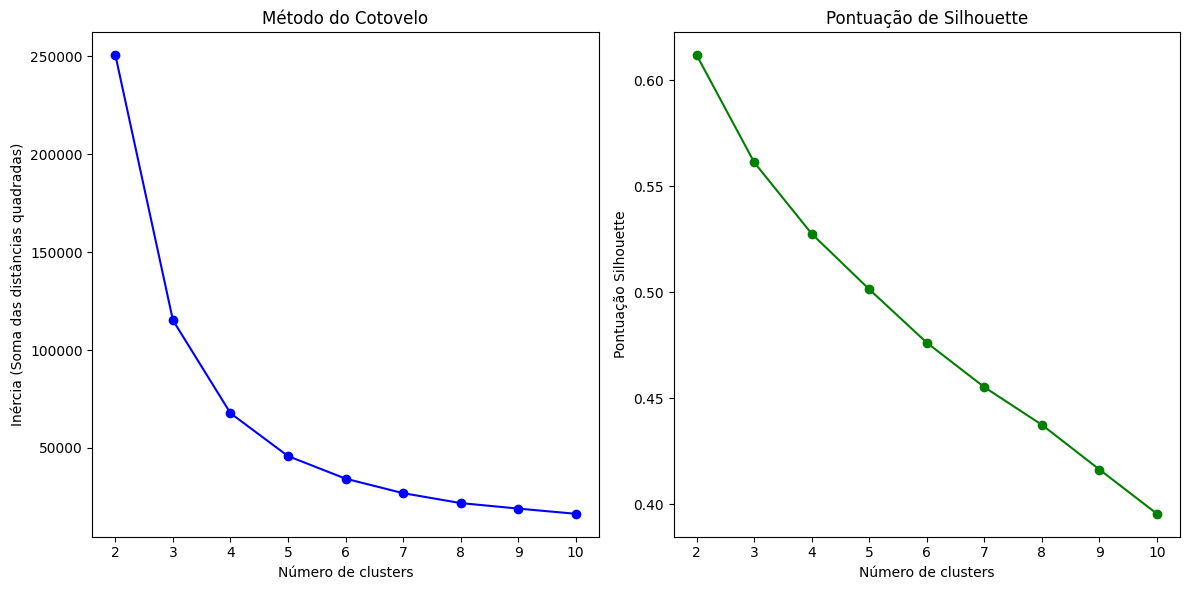

In [ ]:
# Definir intervalo de números de clusters a testar
inertia = []
silhouette_scores = []
max_k = 10  # Máximo número de clusters a testar

for k in range(2, max_k + 1):  # Começa do 2 porque o score de silhueta não é definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_processed)

    inertia.append(kmeans.inertia_)
    # 'Silhouette score'
    score = silhouette_score(df_processed, kmeans.labels_)
    silhouette_scores.append(score)

# Criar os gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico do método do cotovelo (inércia)
ax1.plot(range(2, max_k + 1), inertia, marker='o', color='b')
ax1.set_title('Método do Cotovelo')
ax1.set_xlabel('Número de clusters')
ax1.set_ylabel('Inércia (Soma das distâncias quadradas)')

# Gráfico da pontuação de Silhouette
ax2.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='g')
ax2.set_title('Pontuação de Silhouette')
ax2.set_xlabel('Número de clusters')
ax2.set_ylabel('Pontuação Silhouette')

# Plota e exibe os gráficos
plt.tight_layout()
plt.show()

###7. Aplicar o k-means
Determinar o número de Clusters

In [ ]:
# Definir o número de clusters baseado no Método do Cotovelo e Silhueta
kmeans = KMeans(n_clusters=3, random_state=42)

# Ajustar o modelo KMeans e prever os clusters
df_processed['Cluster'] = kmeans.fit_predict(df_processed)

# Exibir as primeiras linhas com os clusters
df_processed[['Country', 'Cluster']].head()

# Acessar o StandardScaler ajustado do preprocessor
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']

# Reverter a transformação apenas para as colunas numéricas
df_numeric_restored = scaler.inverse_transform(df_processed[numeric_cols])

# Converter os dados numéricos restaurados de volta para um DataFrame com os nomes originais das colunas
df_numeric_restored = pd.DataFrame(df_numeric_restored, columns=numeric_cols)

# Restaurar os valores originais das colunas categóricas usando os mappings salvos
df_processed[categorical_cols] = df_processed[categorical_cols].astype(int)

df_categorical_restored = df_processed[categorical_cols].copy()
for col in categorical_cols:
   # Pega o dicionário específico da coluna (ex: category_mappings['Country'])
   mapping_dict = category_mappings[col]
   # Converte os valores numéricos para os valores originais
   df_categorical_restored[col] = df_processed[col].apply(lambda x: mapping_dict[int(x)])

# Combinar os dados numéricos restaurados com as variáveis categóricas e os clusters
df_restored = pd.concat(
    [df_numeric_restored, df_categorical_restored, df_processed['Cluster']],
    axis=1
)

df_restored.head()

,Agriculture,Arable (%),Area (sq. mi.),Birthrate,Coastline (coast/area ratio),Crops (%),Deathrate,GDP ($ per capita),Industry,Infant mortality (per 1000 births),...,Net migration,Other (%),Phones (per 1000),Pop. Density (per sq. mi.),Population,Service,Country,Region,Climate,Cluster
0,0.380000,12.13,647500.00,46.60,0.00,2.200000e-01,20.34,700.0,0.240000,163.07,...,23.06,87.65,3.2,48.0,31056997.0,0.380000,Afghanistan,ASIA (EX. NEAR EAST),1.0,2
1,0.232000,21.09,28748.00,15.11,1.26,4.420000e+00,5.22,4500.0,0.188000,21.52,...,-4.93,74.49,71.2,124.6,3581655.0,0.579000,Albania,OCEANIA,1.5,2
2,0.101000,3.22,1097556.25,17.14,0.04,2.500000e-01,4.61,6000.0,0.600000,31.00,...,-0.39,96.53,78.1,13.8,32930091.0,0.298000,Algeria,LATIN AMER. & CARIB,1.0,2
3,0.175125,10.00,199.00,22.46,58.29,1.500000e+01,3.27,8000.0,0.215250,9.27,...,-20.71,75.00,259.5,290.4,57794.0,0.608938,American Samoa,NEAR EAST,2.0,2
4,0.044480,2.22,468.00,8.71,0.00,8.881784e-16,6.25,19000.0,0.246083,4.05,...,6.60,97.78,497.2,152.1,71201.0,0.714625,Andorra,BALTICS,1.5,2


###8. Avaliar o Modelo com Silhouette Score

In [ ]:
# Avaliar a qualidade do modelo com Silhouette Score
silhouette_avg = silhouette_score(df_processed, df_processed['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5614075066375017


###9. Visualização dos Clusters com PCA

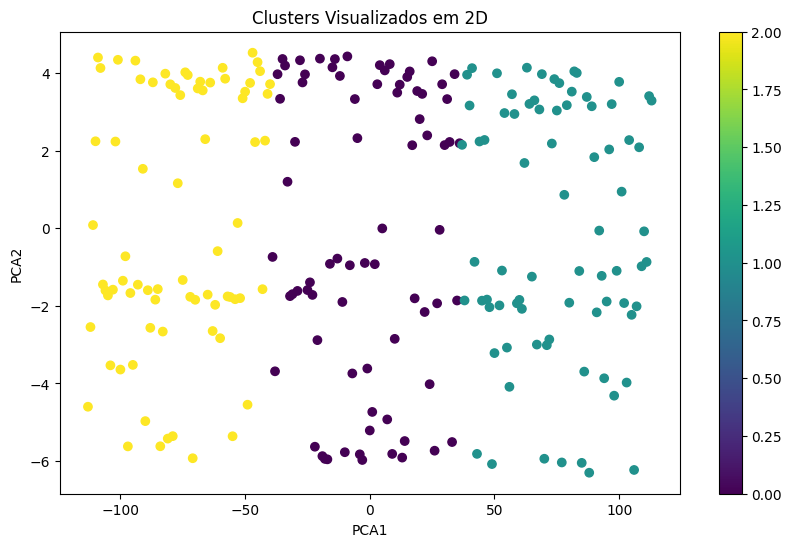

In [ ]:
# Redução de dimensionalidade com PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_processed)

# Visualizar os clusters em 2D
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_processed['Cluster'], cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters Visualizados em 2D')
plt.colorbar(scatter)
plt.show()

### 10. Caracterização dos clusters


In [ ]:
# Caracterização dos clusters

# Define colunas que serão tratadas com moda (colunas categóricas)
cat_cols = ['Country', 'Region', 'Climate']
cat_cols_no_country = ['Region', 'Climate', 'Cluster']

# Agrupa por 'Cluster' e aplica a função apropriada baseada no tipo da coluna:
# - Para colunas categóricas: usa a moda (valor mais frequente)
# - Para colunas numéricas: usa a média
cluster_summary = df_restored.groupby('Cluster').apply(
    lambda group: group.drop(columns=['Country']).apply(
        lambda col: col.mode().iloc[0] if col.name in cat_cols and not col.mode().empty else col.mean()
    )
)

# Converte valores float que são inteiros (ex: 1.0) para formato inteiro (ex: 1)
cluster_summary[cat_cols_no_country] = cluster_summary[cat_cols_no_country].applymap(
    lambda x: int(x) if isinstance(x, float) and x.is_integer() else x
)

# Exibe o resumo das características de cada cluster
print(cluster_summary)
#investir mais em graficos

         Agriculture  Arable (%)  Area (sq. mi.)  Birthrate  \
Cluster                                                       
0           0.152400   14.085778   248660.661184  21.579474   
1           0.147950   13.747532   297917.477273  22.210557   
2           0.147643   13.567432   301373.918919  22.388378   

         Coastline (coast/area ratio)  Crops (%)  Deathrate  \
Cluster                                                       
0                           37.143158   5.355179   9.026842   
1                           14.038961   5.202727   9.048975   
2                           12.170946   3.038108   9.523250   

         GDP ($ per capita)  Industry  Infant mortality (per 1000 births)  \
Cluster                                                                     
0              10209.210526  0.256872                           32.092368   
1               8898.701299  0.304648                           34.063502   
2               9639.189189  0.278423                       